# 04. Time Series Analysis

This notebook performs temporal pattern analysis and time series analysis on the financial news dataset.

**Sections:**
1. **Publication Frequency Over Time** - Hourly, daily, weekly, monthly trends, spike identification, and market event correlation
2. **Publishing Time Analysis** - Hour of day patterns, day of week patterns, and time-of-day heatmaps

**Dependencies:** 
- Run `01_Data_Loading_and_Setup.ipynb` first to create processed data


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from pathlib import Path
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Add utils to path
sys.path.append('.')
from utils import setup_plotting_style, load_processed_data

# Setup plotting style
setup_plotting_style()

print("Libraries imported successfully!")


Plotting style configured
Libraries imported successfully!


In [2]:
# Ensure figures directory exists
figures_dir = 'figures'
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
    print(f"Created {figures_dir}/ directory")
else:
    print(f"Using existing {figures_dir}/ directory")


Using existing figures/ directory


In [3]:
# Load processed data (if available) or load raw data
try:
    df = load_processed_data('../data/processed/df_processed.pkl')
    print(f"Loaded processed data: {df.shape}")
except FileNotFoundError:
    print("Processed data not found. Loading raw data...")
    from utils import load_data, preprocess_data, clean_data
    df = load_data('../data/raw_analyst_ratings.csv')
    df = clean_data(df, remove_duplicates=True, handle_missing='report', fix_dates=True)
    df = preprocess_data(df)
    print(f"Loaded and preprocessed data: {df.shape}")

print(f"\nDataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Ensure date is datetime
if not pd.api.types.is_datetime64_any_dtype(df['date']):
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Extract temporal features (if not already present)
if 'year' not in df.columns:
    df['year'] = df['date'].dt.year
if 'month' not in df.columns:
    df['month'] = df['date'].dt.month
if 'day' not in df.columns:
    df['day'] = df['date'].dt.day
if 'day_of_week' not in df.columns:
    df['day_of_week'] = df['date'].dt.day_name()
if 'hour' not in df.columns:
    df['hour'] = df['date'].dt.hour
if 'date_only' not in df.columns:
    df['date_only'] = df['date'].dt.date

# Filter out invalid dates for temporal analysis
df_valid_dates = df[df['date'].notna()].copy()

print(f"\nValid dates: {len(df_valid_dates):,} ({len(df_valid_dates)/len(df)*100:.2f}%)")
print(f"Date range: {df_valid_dates['date'].min()} to {df_valid_dates['date'].max()}")


Loaded processed data from ../data/processed/df_processed.pkl
Shape: (1407328, 8)
Loaded processed data: (1407328, 8)

Dataset shape: (1407328, 8)
Columns: ['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock', 'headline_length', 'headline_word_count']

Valid dates: 55,987 (3.98%)
Date range: 2011-04-27 21:01:48-04:00 to 2020-06-11 17:12:35-04:00


## 3.1 Publication Frequency Over Time

**Objective:** Analyze publication frequency across different time scales to identify trends, patterns, and spikes.

**Key Questions:**
- What are the hourly, daily, weekly, and monthly publication trends?
- Are there specific spikes in publication activity?
- Can we correlate publication spikes with market events?


In [4]:
# Prepare data for time series analysis
print("="*80)
print("PUBLICATION FREQUENCY OVER TIME")
print("="*80)

# Create time-based aggregations
df_valid_dates['date_dt'] = pd.to_datetime(df_valid_dates['date_only'])

# Daily frequency
daily_counts = df_valid_dates.groupby('date_dt').size().reset_index(name='count')
daily_counts = daily_counts.sort_values('date_dt')

# Monthly frequency
df_valid_dates['year_month'] = df_valid_dates['date'].dt.to_period('M')
monthly_counts = df_valid_dates.groupby('year_month').size().reset_index(name='count')
monthly_counts['year_month_str'] = monthly_counts['year_month'].astype(str)

# Weekly frequency (by week start)
df_valid_dates['week_start'] = df_valid_dates['date_dt'].dt.to_period('W').dt.start_time
weekly_counts = df_valid_dates.groupby('week_start').size().reset_index(name='count')
weekly_counts = weekly_counts.sort_values('week_start')

# Hourly frequency (across all days)
hourly_counts = df_valid_dates.groupby('hour').size().reset_index(name='count')
hourly_counts = hourly_counts.sort_values('hour')

print(f"\nDaily publication frequency:")
print(f"  - Date range: {daily_counts['date_dt'].min()} to {daily_counts['date_dt'].max()}")
print(f"  - Total days with publications: {len(daily_counts):,}")
print(f"  - Mean articles per day: {daily_counts['count'].mean():.1f}")
print(f"  - Median articles per day: {daily_counts['count'].median():.1f}")
print(f"  - Max articles per day: {daily_counts['count'].max():,}")

print(f"\nMonthly publication frequency:")
print(f"  - Total months: {len(monthly_counts):,}")
print(f"  - Mean articles per month: {monthly_counts['count'].mean():.1f}")
print(f"  - Median articles per month: {monthly_counts['count'].median():.1f}")
print(f"  - Max articles per month: {monthly_counts['count'].max():,}")

print(f"\nHourly publication frequency:")
print(f"  - Mean articles per hour: {hourly_counts['count'].mean():.1f}")
print(f"  - Peak hour: {hourly_counts.loc[hourly_counts['count'].idxmax(), 'hour']}:00 ({hourly_counts['count'].max():,} articles)")


PUBLICATION FREQUENCY OVER TIME

Daily publication frequency:
  - Date range: 2011-04-27 00:00:00 to 2020-06-11 00:00:00
  - Total days with publications: 2,528
  - Mean articles per day: 22.1
  - Median articles per day: 9.0
  - Max articles per day: 973

Monthly publication frequency:
  - Total months: 111
  - Mean articles per month: 504.4
  - Median articles per month: 258.0
  - Max articles per month: 9,333

Hourly publication frequency:
  - Mean articles per hour: 2332.8
  - Peak hour: 10.0:00 (7,669 articles)


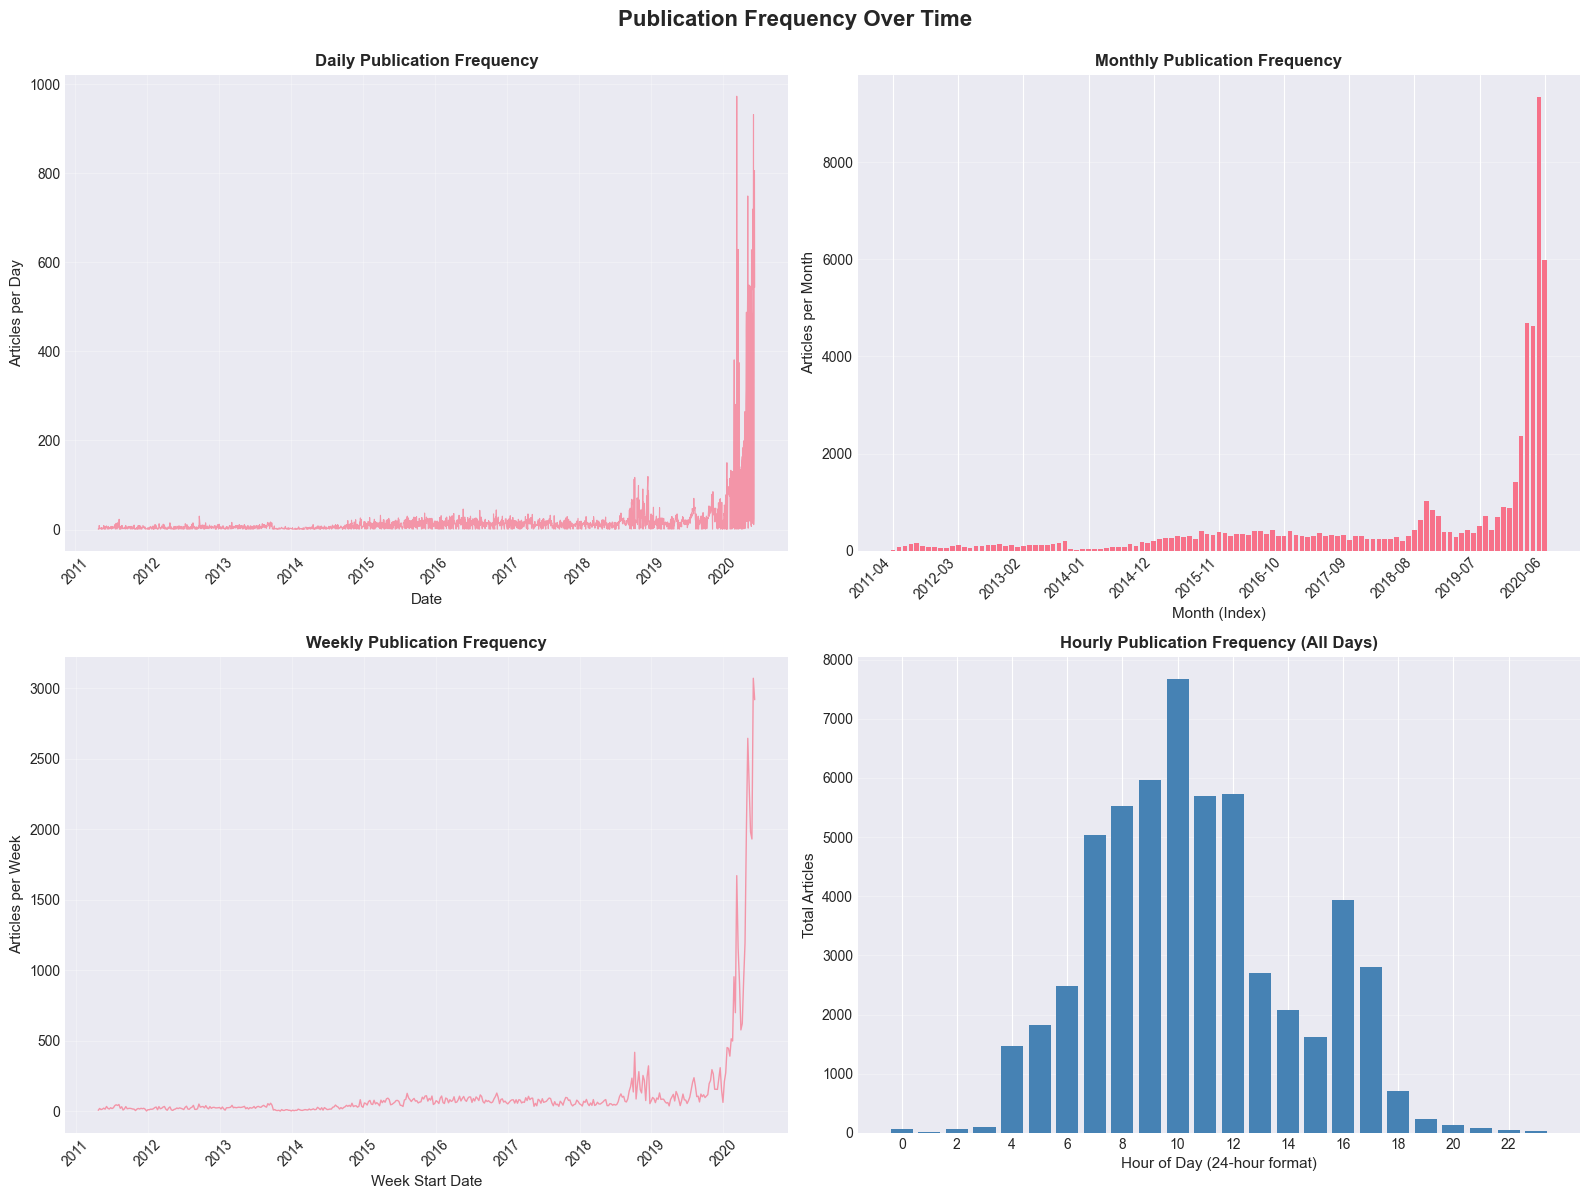

Saved: figures/publication_frequency_over_time.png


In [5]:
# Visualize publication frequency over time
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Publication Frequency Over Time', fontsize=16, fontweight='bold', y=0.995)

# 1. Daily frequency (time series)
ax1 = axes[0, 0]
ax1.plot(daily_counts['date_dt'], daily_counts['count'], linewidth=0.8, alpha=0.7)
ax1.set_xlabel('Date', fontsize=11)
ax1.set_ylabel('Articles per Day', fontsize=11)
ax1.set_title('Daily Publication Frequency', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 2. Monthly frequency (bar chart)
ax2 = axes[0, 1]
monthly_counts_sorted = monthly_counts.sort_values('year_month')
ax2.bar(range(len(monthly_counts_sorted)), monthly_counts_sorted['count'], width=0.8)
ax2.set_xlabel('Month (Index)', fontsize=11)
ax2.set_ylabel('Articles per Month', fontsize=11)
ax2.set_title('Monthly Publication Frequency', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
# Set x-axis labels for every 12 months
n_months = len(monthly_counts_sorted)
step = max(1, n_months // 10)
ax2.set_xticks(range(0, n_months, step))
ax2.set_xticklabels([monthly_counts_sorted.iloc[i]['year_month_str'] for i in range(0, n_months, step)], rotation=45, ha='right')

# 3. Weekly frequency (time series)
ax3 = axes[1, 0]
ax3.plot(weekly_counts['week_start'], weekly_counts['count'], linewidth=1, alpha=0.7)
ax3.set_xlabel('Week Start Date', fontsize=11)
ax3.set_ylabel('Articles per Week', fontsize=11)
ax3.set_title('Weekly Publication Frequency', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# 4. Hourly frequency (bar chart)
ax4 = axes[1, 1]
ax4.bar(hourly_counts['hour'], hourly_counts['count'], width=0.8, color='steelblue')
ax4.set_xlabel('Hour of Day (24-hour format)', fontsize=11)
ax4.set_ylabel('Total Articles', fontsize=11)
ax4.set_title('Hourly Publication Frequency (All Days)', fontsize=12, fontweight='bold')
ax4.set_xticks(range(0, 24, 2))
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/publication_frequency_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: figures/publication_frequency_over_time.png")



PUBLICATION SPIKE DETECTION

Spike Detection Parameters:
  - Mean articles per day: 22.1
  - Standard deviation: 68.1
  - Threshold (>2 std dev): 158.4 articles/day
  - Number of spike days: 51 (2.02%)

Top 20 Publication Spikes:
--------------------------------------------------------------------------------
2020-03-12: 973 articles (43.9x average)
2020-06-05: 932 articles (42.1x average)
2020-06-10: 806 articles (36.4x average)
2020-06-09: 804 articles (36.3x average)
2020-06-08: 765 articles (34.5x average)
2020-05-07: 749 articles (33.8x average)
2020-06-03: 720 articles (32.5x average)
2020-03-19: 629 articles (28.4x average)
2020-05-26: 628 articles (28.4x average)
2020-05-13: 549 articles (24.8x average)
2020-05-18: 547 articles (24.7x average)
2020-06-11: 544 articles (24.6x average)
2020-06-04: 538 articles (24.3x average)
2020-05-14: 536 articles (24.2x average)
2020-05-06: 531 articles (24.0x average)
2020-05-08: 508 articles (22.9x average)
2020-05-27: 492 articles (22.2x 

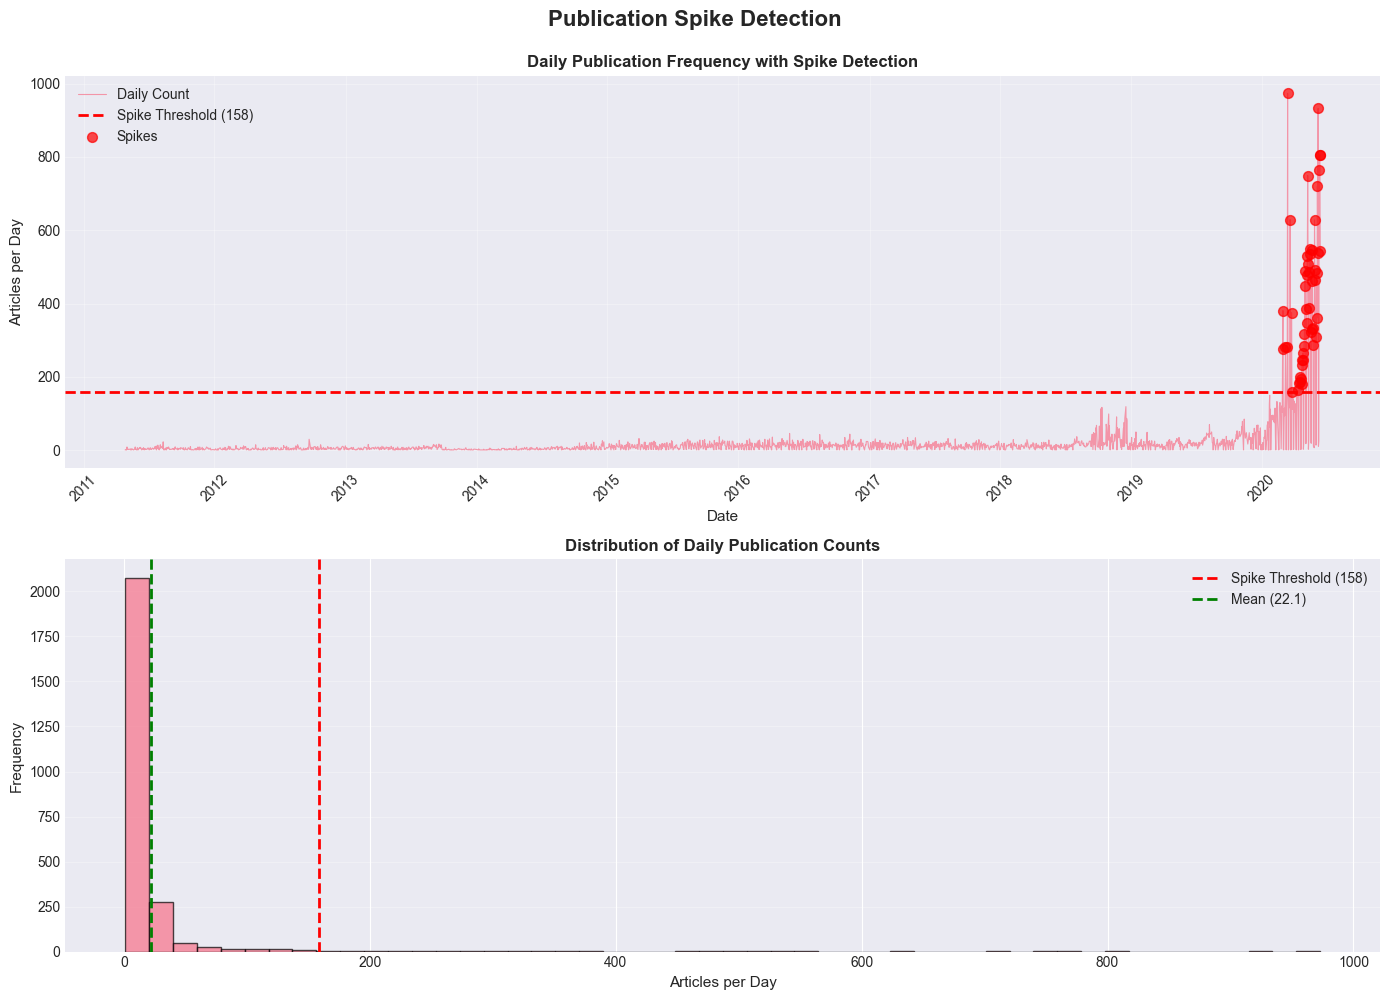


Saved: figures/publication_spikes.png


In [6]:
# Identify publication spikes (days with unusually high article counts)
print("\n" + "="*80)
print("PUBLICATION SPIKE DETECTION")
print("="*80)

# Calculate statistics for spike detection
mean_daily = daily_counts['count'].mean()
std_daily = daily_counts['count'].std()
threshold = mean_daily + 2 * std_daily  # 2 standard deviations above mean

spikes = daily_counts[daily_counts['count'] >= threshold].copy()
spikes = spikes.sort_values('count', ascending=False)

print(f"\nSpike Detection Parameters:")
print(f"  - Mean articles per day: {mean_daily:.1f}")
print(f"  - Standard deviation: {std_daily:.1f}")
print(f"  - Threshold (>2 std dev): {threshold:.1f} articles/day")
print(f"  - Number of spike days: {len(spikes):,} ({len(spikes)/len(daily_counts)*100:.2f}%)")

print(f"\nTop 20 Publication Spikes:")
print("-" * 80)
for idx, row in spikes.head(20).iterrows():
    print(f"{row['date_dt'].strftime('%Y-%m-%d')}: {row['count']:,} articles ({row['count']/mean_daily:.1f}x average)")

# Visualize spikes
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
fig.suptitle('Publication Spike Detection', fontsize=16, fontweight='bold', y=0.995)

# Plot 1: Daily frequency with spike threshold
ax1 = axes[0]
ax1.plot(daily_counts['date_dt'], daily_counts['count'], linewidth=0.8, alpha=0.7, label='Daily Count')
ax1.axhline(y=threshold, color='r', linestyle='--', linewidth=2, label=f'Spike Threshold ({threshold:.0f})')
ax1.scatter(spikes['date_dt'], spikes['count'], color='red', s=50, alpha=0.7, zorder=5, label='Spikes')
ax1.set_xlabel('Date', fontsize=11)
ax1.set_ylabel('Articles per Day', fontsize=11)
ax1.set_title('Daily Publication Frequency with Spike Detection', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Distribution of daily counts
ax2 = axes[1]
ax2.hist(daily_counts['count'], bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(x=threshold, color='r', linestyle='--', linewidth=2, label=f'Spike Threshold ({threshold:.0f})')
ax2.axvline(x=mean_daily, color='g', linestyle='--', linewidth=2, label=f'Mean ({mean_daily:.1f})')
ax2.set_xlabel('Articles per Day', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Distribution of Daily Publication Counts', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/publication_spikes.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved: figures/publication_spikes.png")


## 3.2 Publishing Time Analysis

**Objective:** Analyze patterns in publishing times to understand when news is most frequently published.

**Key Questions:**
- What hours of the day see the most publication activity?
- Are there differences in publication patterns by day of the week?
- What does a time-of-day heatmap reveal about publication patterns?


In [7]:
# Analyze publishing time patterns
print("="*80)
print("PUBLISHING TIME ANALYSIS")
print("="*80)

# Day of week analysis
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = df_valid_dates.groupby('day_of_week').size().reset_index(name='count')
day_counts['day_of_week'] = pd.Categorical(day_counts['day_of_week'], categories=day_order, ordered=True)
day_counts = day_counts.sort_values('day_of_week')

print(f"\nArticles by Day of Week:")
for _, row in day_counts.iterrows():
    pct = row['count'] / len(df_valid_dates) * 100
    print(f"  {row['day_of_week']:12s}: {row['count']:8,} articles ({pct:5.2f}%)")

print(f"\nArticles by Hour of Day:")
for _, row in hourly_counts.iterrows():
    pct = row['count'] / len(df_valid_dates) * 100
    print(f"  {row['hour']:2d}:00 - {row['hour']:2d}:59: {row['count']:8,} articles ({pct:5.2f}%)")


PUBLISHING TIME ANALYSIS

Articles by Day of Week:
  Monday      :   10,322 articles (18.44%)
  Tuesday     :   11,002 articles (19.65%)
  Wednesday   :   11,891 articles (21.24%)
  Thursday    :   12,688 articles (22.66%)
  Friday      :    9,381 articles (16.76%)
  Saturday    :      267 articles ( 0.48%)
  Sunday      :      436 articles ( 0.78%)

Articles by Hour of Day:


ValueError: Unknown format code 'd' for object of type 'float'

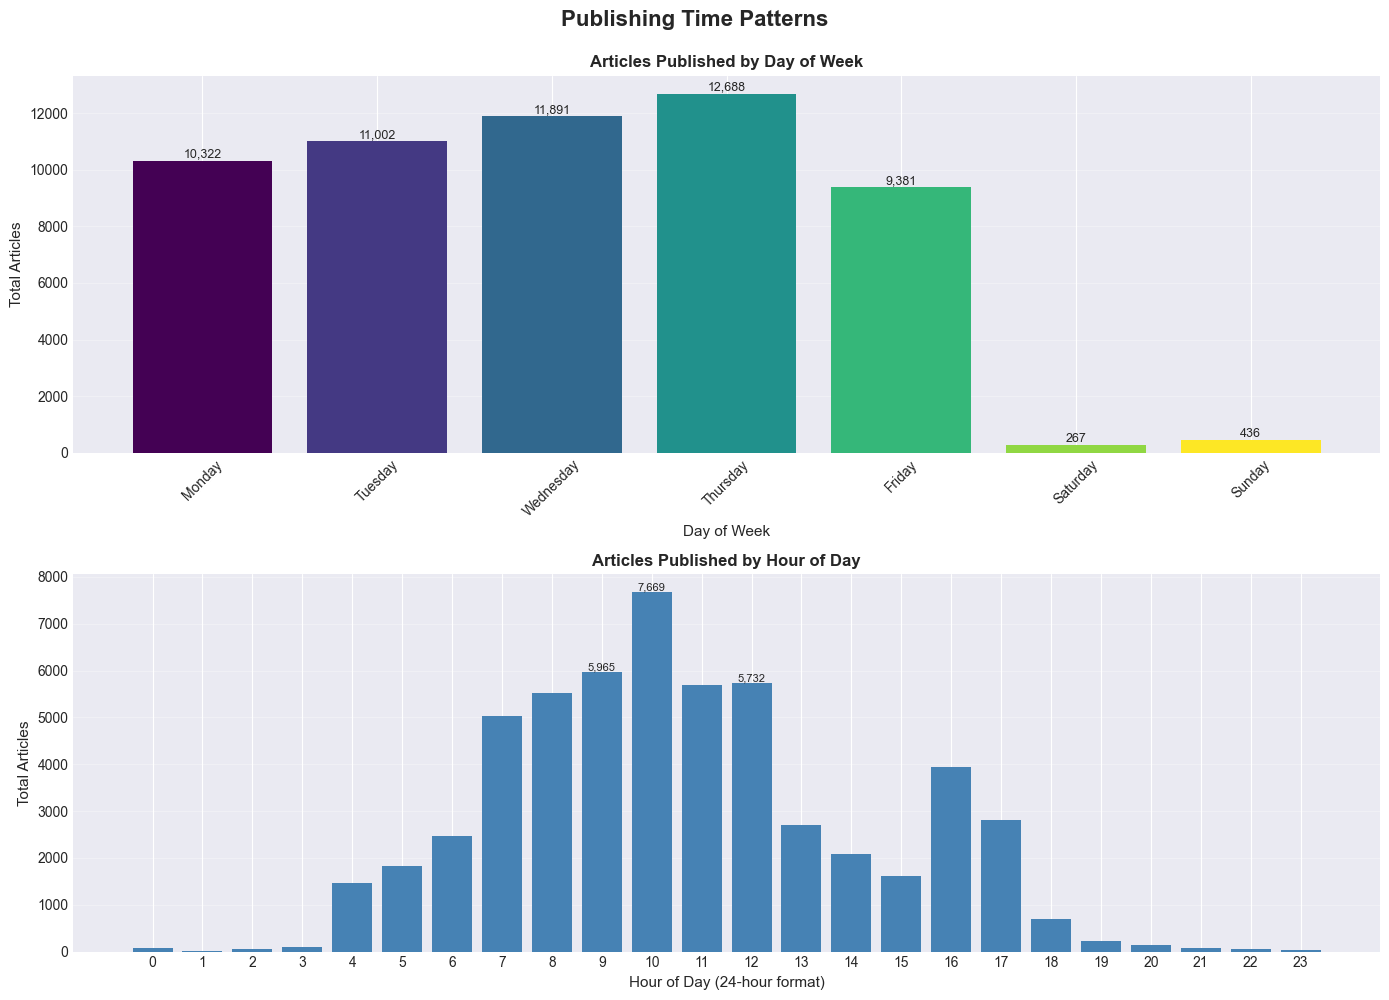

Saved: figures/publishing_time_patterns.png


In [9]:
# Visualize day of week and hour patterns
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
fig.suptitle('Publishing Time Patterns', fontsize=16, fontweight='bold', y=0.995)

# Plot 1: Day of week
ax1 = axes[0]
colors = plt.cm.viridis(np.linspace(0, 1, len(day_counts)))
bars = ax1.bar(day_counts['day_of_week'], day_counts['count'], color=colors)
ax1.set_xlabel('Day of Week', fontsize=11)
ax1.set_ylabel('Total Articles', fontsize=11)
ax1.set_title('Articles Published by Day of Week', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=9)

# Plot 2: Hour of day
ax2 = axes[1]
ax2.bar(hourly_counts['hour'], hourly_counts['count'], width=0.8, color='steelblue')
ax2.set_xlabel('Hour of Day (24-hour format)', fontsize=11)
ax2.set_ylabel('Total Articles', fontsize=11)
ax2.set_title('Articles Published by Hour of Day', fontsize=12, fontweight='bold')
ax2.set_xticks(range(0, 24))
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on top bars
for _, row in hourly_counts.iterrows():
    if row['count'] > hourly_counts['count'].quantile(0.9):  # Label top 10%
        ax2.text(row['hour'], row['count'], f"{int(row['count']):,}",
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('figures/publishing_time_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: figures/publishing_time_patterns.png")



TIME-OF-DAY HEATMAP ANALYSIS

Heatmap dimensions: (7, 24)
Total articles in heatmap: 55,987.0


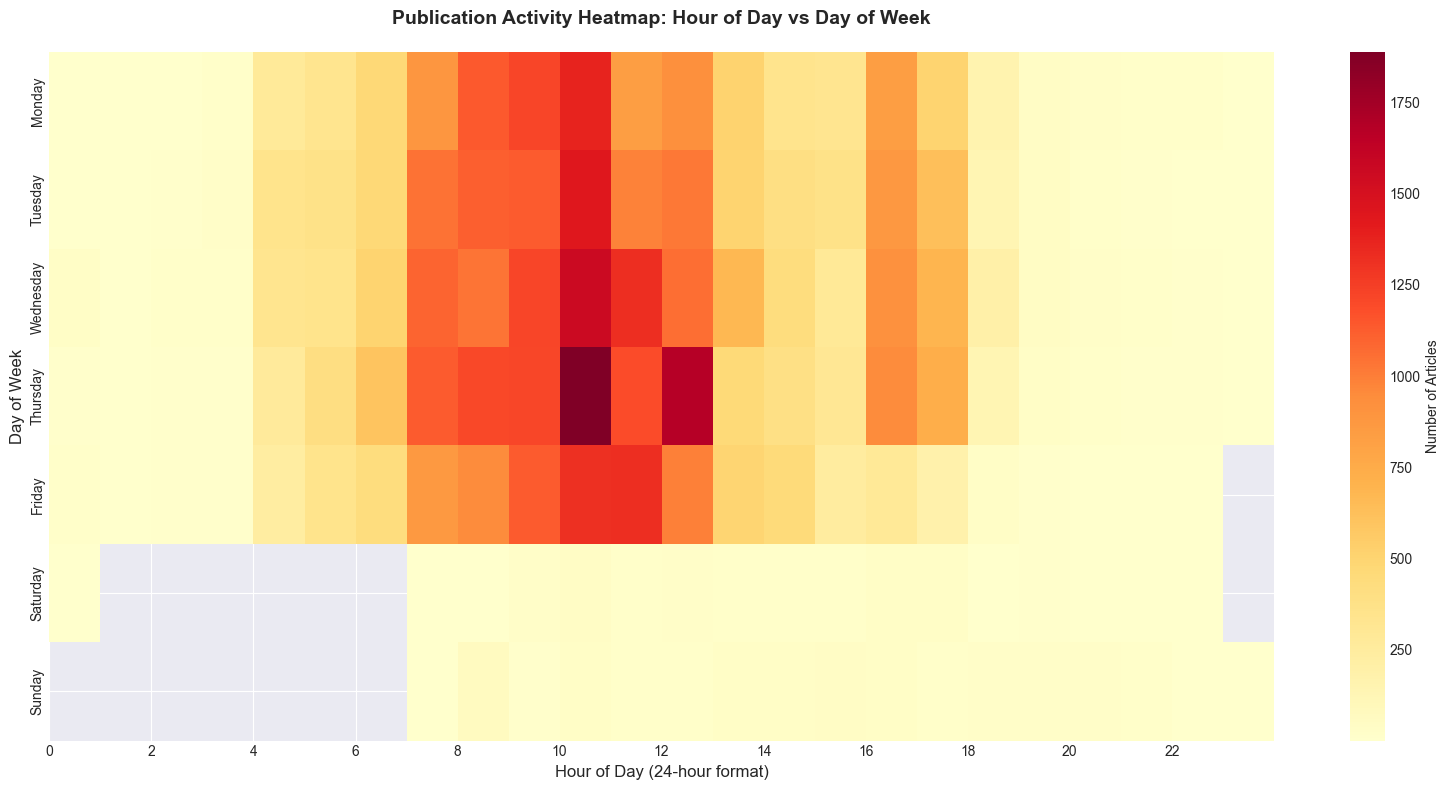


Saved: figures/time_of_day_heatmap.png


In [8]:
# Create time-of-day heatmap (hour vs day of week)
print("\n" + "="*80)
print("TIME-OF-DAY HEATMAP ANALYSIS")
print("="*80)

# Create pivot table for heatmap
heatmap_data = df_valid_dates.groupby(['day_of_week', 'hour']).size().reset_index(name='count')
heatmap_pivot = heatmap_data.pivot(index='day_of_week', columns='hour', values='count')

# Reorder days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_pivot = heatmap_pivot.reindex([day for day in day_order if day in heatmap_pivot.index])

# Fill missing hours with 0
for hour in range(24):
    if hour not in heatmap_pivot.columns:
        heatmap_pivot[hour] = 0
heatmap_pivot = heatmap_pivot.sort_index(axis=1)

print(f"\nHeatmap dimensions: {heatmap_pivot.shape}")
print(f"Total articles in heatmap: {heatmap_pivot.sum().sum():,}")

# Visualize heatmap
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(heatmap_pivot, annot=False, fmt='d', cmap='YlOrRd', cbar_kws={'label': 'Number of Articles'}, ax=ax)
ax.set_xlabel('Hour of Day (24-hour format)', fontsize=12)
ax.set_ylabel('Day of Week', fontsize=12)
ax.set_title('Publication Activity Heatmap: Hour of Day vs Day of Week', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(range(0, 24, 2))
ax.set_xticklabels(range(0, 24, 2))

plt.tight_layout()
plt.savefig('figures/time_of_day_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved: figures/time_of_day_heatmap.png")



YEARLY PUBLICATION PATTERNS

Articles by Year:
  2011:    760.0 articles ( 1.36%)
  2012:  1,187.0 articles ( 2.12%)
  2013:  1,240.0 articles ( 2.21%)
  2014:  1,189.0 articles ( 2.12%)
  2015:  3,695.0 articles ( 6.60%)
  2016:  4,223.0 articles ( 7.54%)
  2017:  3,581.0 articles ( 6.40%)
  2018:  5,395.0 articles ( 9.64%)
  2019:  6,325.0 articles (11.30%)
  2020: 28,392.0 articles (50.71%)


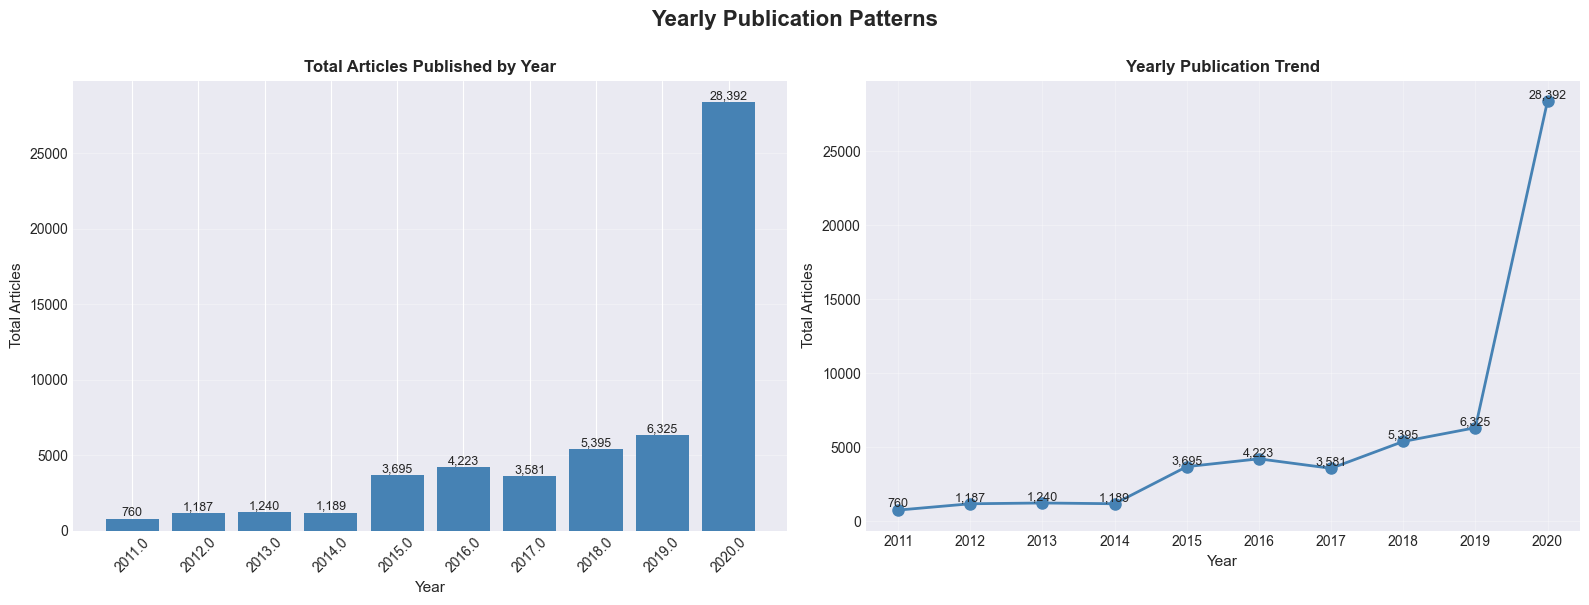


Saved: figures/yearly_publication_patterns.png


In [10]:
# Additional analysis: Publication patterns by year
print("\n" + "="*80)
print("YEARLY PUBLICATION PATTERNS")
print("="*80)

yearly_counts = df_valid_dates.groupby('year').size().reset_index(name='count')
yearly_counts = yearly_counts.sort_values('year')

print(f"\nArticles by Year:")
for _, row in yearly_counts.iterrows():
    pct = row['count'] / len(df_valid_dates) * 100
    print(f"  {int(row['year'])}: {row['count']:8,} articles ({pct:5.2f}%)")

# Visualize yearly trends
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Yearly Publication Patterns', fontsize=16, fontweight='bold', y=1.0)

# Plot 1: Bar chart
ax1 = axes[0]
bars = ax1.bar(yearly_counts['year'].astype(str), yearly_counts['count'], color='steelblue')
ax1.set_xlabel('Year', fontsize=11)
ax1.set_ylabel('Total Articles', fontsize=11)
ax1.set_title('Total Articles Published by Year', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
ax1.tick_params(axis='x', rotation=45)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=9)

# Plot 2: Line chart with trend
ax2 = axes[1]
ax2.plot(yearly_counts['year'], yearly_counts['count'], marker='o', linewidth=2, markersize=8, color='steelblue')
ax2.set_xlabel('Year', fontsize=11)
ax2.set_ylabel('Total Articles', fontsize=11)
ax2.set_title('Yearly Publication Trend', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(yearly_counts['year'])

# Add value labels
for _, row in yearly_counts.iterrows():
    ax2.text(row['year'], row['count'], f"{int(row['count']):,}",
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('figures/yearly_publication_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved: figures/yearly_publication_patterns.png")


## Summary and Key Findings

**Key Insights from Time Series Analysis:**

1. **Publication Frequency Trends:**
   - [To be filled after running the notebook]

2. **Spike Detection:**
   - [To be filled after running the notebook]

3. **Publishing Time Patterns:**
   - [To be filled after running the notebook]

4. **Temporal Patterns:**
   - [To be filled after running the notebook]
